### Imports

In [364]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

from typing import List

from ipywidgets import interact
import ipywidgets as widgets

from scipy.integrate import simpson

### Constantes

In [365]:
YEARS = 10
PI = np.pi
DELTA = 1/365

### Funciones utiles

In [366]:
#para viento promedio
def theta(i):
    """Funcion de tita(i) demuestra la relacion del viento a medida que cambian las estaciones
    """
    return 6 +  2* np.cos(2 * PI * i / 365)

def nextDay_regional(i ,Si ,K ,sigma):
    """Modelo de el viento promedio de la region en cada dia i"""
    return Si + K*(theta(i) - Si) * DELTA + sigma * DELTA**0.5 * np.random.normal(0,1)

def simulateTrip_regional(k , sigma, S0 = 8):
    """Modelado para el viento regional, simula lo que searia tantos años entero de viento"""
    days = np.arange(0, 365 * YEARS, 1)
    shoks = np.random.normal(0, 1, len(days))
    trip = [S0]
    for i in days:
        Si = trip[-1]
        trip.append(nextDay_regional(i,Si, k, sigma))
    return trip

#Para el wind gap
def nextDay_windgap(Di, beta, gamma):
    """Modelo de la diferencia de viento entre el molino norte y sur cada dia i"""
    return Di - beta * Di * DELTA + gamma * DELTA**0.5 * np.random.normal(0,1)


def simulateTrip_windgap(beta, gamma):
    """Modelado para la diferencia de viento entre el molino norte y sur, simula lo que searia tantos años de viento"""
    days = np.arange(0, 365 * YEARS, 1)
    trip = [0]
    for i in days:
        a = nextDay_windgap(trip[-1], beta, gamma)
        trip.append(nextDay_windgap(trip[-1], beta, gamma))
    return trip



# 1

## Estimar viento regional

### Cargamos los datos

In [367]:
data = pd.read_excel("Wind data for TP1.xlsx")

In [368]:
data.head()
data.describe()

,dia,regional wind,wind gap norte sur
count,3650.000000,3650.000000,3650.000000
mean,1825.500000,5.964443,0.030786
std,1053.808569,1.803460,1.061618
min,1.000000,0.561755,-3.113338
25%,913.250000,4.635071,-0.707190
50%,1825.500000,5.953573,0.035121
75%,2737.750000,7.277698,0.741384
max,3650.000000,10.855314,3.936470


### Constantes

In [369]:
S0 = data["regional wind"][0]
D0 = data["wind gap norte sur"][0]
N = data.shape[0]

### Calculamos la diferencia entre Si+1  - Si

In [370]:
# modelo del molino
# Si+1 = Si + κ(θ(ti) −Si)∆ + σ√∆ Zi (1)
# Si+1  - Si = κ(θ(ti) −Si)∆ + σ√∆ Zi 

In [371]:
# new column with the diff between one day and the previous one
data["diff_regional"] = data["regional wind"].diff().shift(-1)

data.head()

,dia,regional wind,wind gap norte sur,diff_regional
0,1,8.000000,0.000000,0.346296
1,2,8.346296,0.181523,1.716019
2,3,10.062316,0.188643,0.729021
3,4,10.791337,0.071085,-0.037244
4,5,10.754093,0.078442,0.017364


### Regresion Lineal 

In [372]:
# Supongamos que tienes los datos en un DataFrame
# df['S'] es la columna de la variable S
# df['theta'] es la columna de la variable θ(t)
# Δ es el tamaño de paso del tiempo

# Calcular las diferencias Y_i = S_{i+1} - S_i
data['diff_regional'] = data['regional wind'].diff().shift(-1)

# Calcular X1_i = (θ(t_i) - S_i) * Δ
data['X1'] = (theta(data["regional wind"][:-1].index.values) - data["regional wind"][:-1]) * DELTA

# Calcular Z_i como el residuo de Y y X1
# Suponiendo que tienes alguna estimación de Z_i, si no, deberás calcularla
# Z_i es N(0,1) distribuido normalmente, por lo que puedes modelarlo a partir del residuo
# Por simplicidad, puedes asumir que Z_i es un vector aleatorio para fines de regresión.

# Crear el modelo de regresión
X_regional_wind = data[['X1']][1:-1]
Y_regional_wind = data['diff_regional'][1:-1]
print("NULOS:  " + str( X_regional_wind.isnull().sum()))

# Ajustar el modelo de regresión
model = LinearRegression()
model.fit(X_regional_wind, Y_regional_wind)

# Obtener el valor de kappa (pendiente)
kappa = model.coef_[0]

# El valor de sigma puede necesitar un análisis adicional si lo deseas estimar explícitamente
# como sigma * sqrt(Δ). Esto puede derivarse a través de los residuos.

print(f"Valor estimado de kappa: {kappa}")


NULOS:  X1    0
dtype: int64
Valor estimado de kappa: 109.25770145796069


### Calculamos Sigma

In [373]:
# Calcular los residuos de la regresión
error_RW = Y_regional_wind - model.predict(X_regional_wind)
var_RW = error_RW.var()
sigma = np.sqrt(var_RW / DELTA)

print(f"Valor estimado de sigma: {sigma}")

Valor estimado de sigma: 16.047720266718766


### Graficos: Simulacion de viento promedio para ambos molinos

In [374]:
kappa, sigma

(109.25770145796069, 16.047720266718766)

109.25770145796069 16.047720266718766


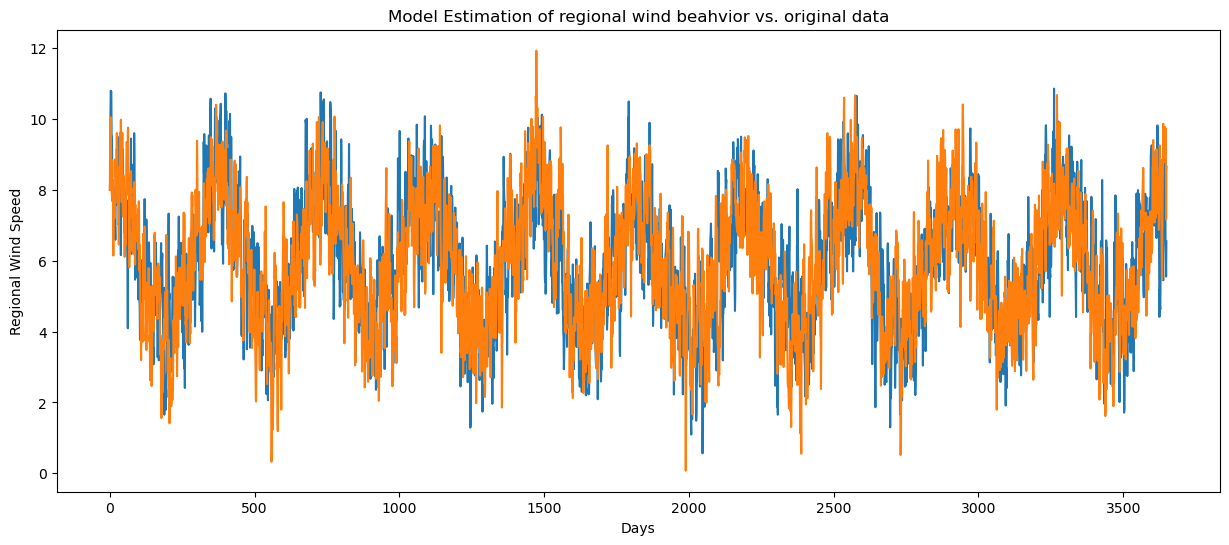

In [375]:
plt.figure(figsize=(15, 6))

# graficar data
plt.plot(data['regional wind'])

# graficar modelo predicgo

print(kappa, sigma)
modelo_viento_promedio = simulateTrip_regional(109, sigma,S0=8)
plt.plot(modelo_viento_promedio)
plt.title("Model Estimation of regional wind beahvior vs. original data")
plt.xlabel("Days")
plt.ylabel("Regional Wind Speed")
plt.show()


### Medidas de error para el viento promedio

In [376]:
### medidas de error de datos reales

# Convertir los valores reales en un array de numpy para compararlos con los valores simulados
data_viento_regional = data['regional wind'].values

modelo_viento_promedio_acortado = np.array(modelo_viento_promedio[:len(data_viento_regional)])

# Calcular los valores máximo y mínimo de la diferencia de viento
viento_promedio_max = data['regional wind'].max()
viento_promedio_min = data['regional wind'].min()

maxima_variacion_VP = viento_promedio_max - viento_promedio_min


# Calcular la varianza de la diferencia de viento
viento_promedio_variance = data['regional wind'].var()

# Calcular la desviación estándar de la diferencia de viento
viento_promedio_std = data['regional wind'].std()

# Mostrar los resultados
print("Analisis de distribucion de datos reales:")
print(f"Max-Min: [ {viento_promedio_min:.2f} , {viento_promedio_max:.2f} ]")
print(f"Variacion del viento promeido: {maxima_variacion_VP:.2f}")
print(f"Varianza de la viento promedio: {viento_promedio_variance:.2f}")
print(f"Desviación estándar de la viento promeido: {viento_promedio_std:.2f}")

### medidas de error entre el modelo y datoss reales

# Calcular los errores entre los valores simulados y los valores reales
errores_viento_promedio = data_viento_regional - modelo_viento_promedio_acortado

# Calcular el RMSE entre los valores simulados y los valores reales
rmse_viento_promedio = np.sqrt(mean_squared_error(data_viento_regional, modelo_viento_promedio_acortado))
# Calcular la varianza del error
varianza_error = np.var(errores_viento_promedio)

# Calcular la desviación estándar del error
desviacion_estandar_error = np.std(errores_viento_promedio)
# Calcular el MAE

mae_viento_promedio = mean_absolute_error(data_viento_regional, modelo_viento_promedio_acortado)

# Calcular el R^2
r2_viento_promedio = r2_score(data_viento_regional, modelo_viento_promedio_acortado)

# Calcular los errores (residuos)
residuals_VP = data['regional wind'][:len(modelo_viento_promedio_acortado)] - modelo_viento_promedio_acortado


# Mostrar los resultados
print("\nAnalisis del modelo:")
print(f"Varianza del error: {varianza_error:.2f}")
print(f"Desviación estándar del error: {desviacion_estandar_error:.2f}")
print(f"RMSE: {rmse_viento_promedio:.2f}")
print(f"MAE: {mae_viento_promedio:.2f}")
print(f"R²: {r2_viento_promedio:.2f}")



Analisis de distribucion de datos reales:
Max-Min: [ 0.56 , 10.86 ]
Variacion del viento promeido: 10.29
Varianza de la viento promedio: 3.25
Desviación estándar de la viento promeido: 1.80

Analisis del modelo:
Varianza del error: 2.51
Desviación estándar del error: 1.59
RMSE: 1.59
MAE: 1.27
R²: 0.23


El modelo tiene un rendimiento moderado en términos de precisión (RMSE y MAE son razonables), pero su capacidad de explicación y ajuste es baja (como lo indica el 𝑅^2). Esto sugiere que aunque el modelo predice con cierto grado de precisión, no está capturando bien las tendencias subyacentes en los datos

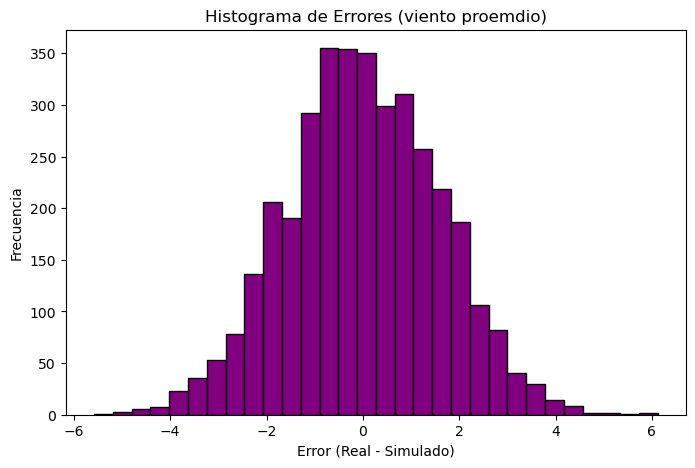

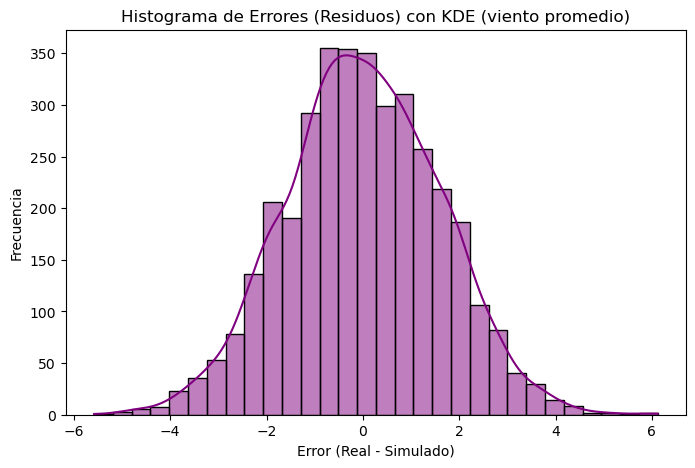

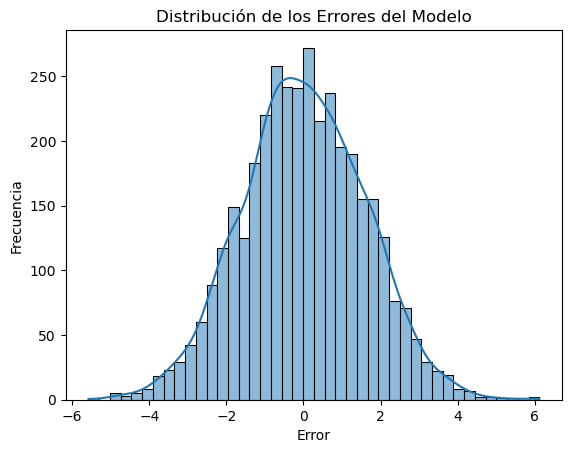

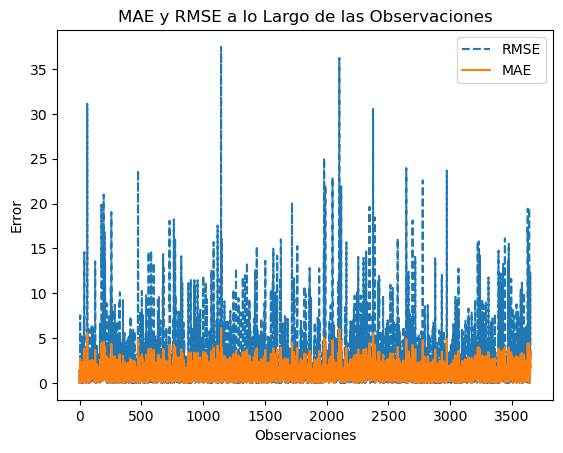

In [377]:

plt.figure(figsize=(8, 5))
plt.hist(residuals_VP, bins=30, color='purple', edgecolor='black')
plt.title('Histograma de Errores (viento proemdio)')
plt.xlabel('Error (Real - Simulado)')
plt.ylabel('Frecuencia')
plt.show()

# Graficar el histograma con Seaborn
plt.figure(figsize=(8, 5))
sns.histplot(residuals_VP, bins=30, kde=True, color='purple')
plt.title('Histograma de Errores (Residuos) con KDE (viento promedio)')
plt.xlabel('Error (Real - Simulado)')
plt.ylabel('Frecuencia')
plt.show()

sns.histplot(errores_viento_promedio, kde=True)
plt.title('Distribución de los Errores del Modelo')
plt.xlabel('Error')
plt.ylabel('Frecuencia')
plt.show()



plt.plot(range(len(errores_viento_promedio)), errores_viento_promedio**2, label='RMSE', linestyle='--')
plt.plot(range(len(errores_viento_promedio)), np.abs(errores_viento_promedio), label='MAE')

plt.title('MAE y RMSE a lo Largo de las Observaciones')
plt.xlabel('Observaciones')
plt.ylabel('Error')
plt.legend()
plt.show()


## Estimar diferencia entre molinos

### Calculamos la diferencia Di+1 - Di

In [378]:
# new column with the diff between one day and the previous one

data["diff_wind_gap"] = data["wind gap norte sur"].diff().shift(-1)

data.head()

,dia,regional wind,wind gap norte sur,diff_regional,X1,diff_wind_gap
0,1,8.000000,0.000000,0.346296,0.000000,0.181523
1,2,8.346296,0.181523,1.716019,-0.000950,0.007120
2,3,10.062316,0.188643,0.729021,-0.005653,-0.117558
3,4,10.791337,0.071085,-0.037244,-0.007655,0.007358
4,5,10.754093,0.078442,0.017364,-0.007558,0.563745


### Regresion lineal

In [379]:
# Diferencia entre molinos

#Di+1 = Di −βDi∆ + γ√∆ Wi (2)
#Di+1 - Di = βDi∆ + 0 (2)

# Calcular las diferencias Y_i = D_{i+1} - D_i
data['diff_wind_gap'] = data['wind gap norte sur'].diff().shift(-1)

# Calcular X1_i = (-Di) * Δ 
data['X_wind_gap'] = -1 *data["wind gap norte sur"][1:] * DELTA 

# Calcular W_i como el residuo de Y y X1
# Suponiendo que tienes alguna estimación de W_i, si no, deberás calcularla
# W_i es N(0,1) distribuido normalmente, por lo que puedes modelarlo a partir del residuo
# Por simplicidad, puedes asumir que W_i es un vector aleatorio para fines de regresión.

# Crear el modelo de regresión
X_wind_gap = data[['X_wind_gap']][1:-1]
Y_wind_gap = data[['diff_wind_gap']][1:-1]
print("NULOS:  " + str( X_wind_gap.isnull().sum()))

# Ajustar el modelo de regresión
model = LinearRegression()
model.fit(X_wind_gap, Y_wind_gap)


# Obtener el valor de beta (pendiente)
beta = model.coef_[0][0]


print(f"Valor estimado de beta: {beta}")


NULOS:  X_wind_gap    0
dtype: int64
Valor estimado de beta: 48.37684937653269


### Calculamos gamma

In [380]:
# Calcular los residuos de la regresión

Y_wind_gap_np = np.array(Y_wind_gap)
predicted_wind_gap_np = np.array(model.predict(X_wind_gap))

# Calcular el error
error_WG = Y_wind_gap_np - predicted_wind_gap_np
var_WG = error_WG.var()
gamma = np.sqrt(var_WG / DELTA)

print(f"Valor estimado de gamma: {gamma}")



Valor estimado de gamma: 10.091946894398104


### Graficos: Simulacion de diferencia de viente entre ambos molinos

In [381]:
beta, gamma

(48.37684937653269, 10.091946894398104)

48.37684937653269 10.091946894398104


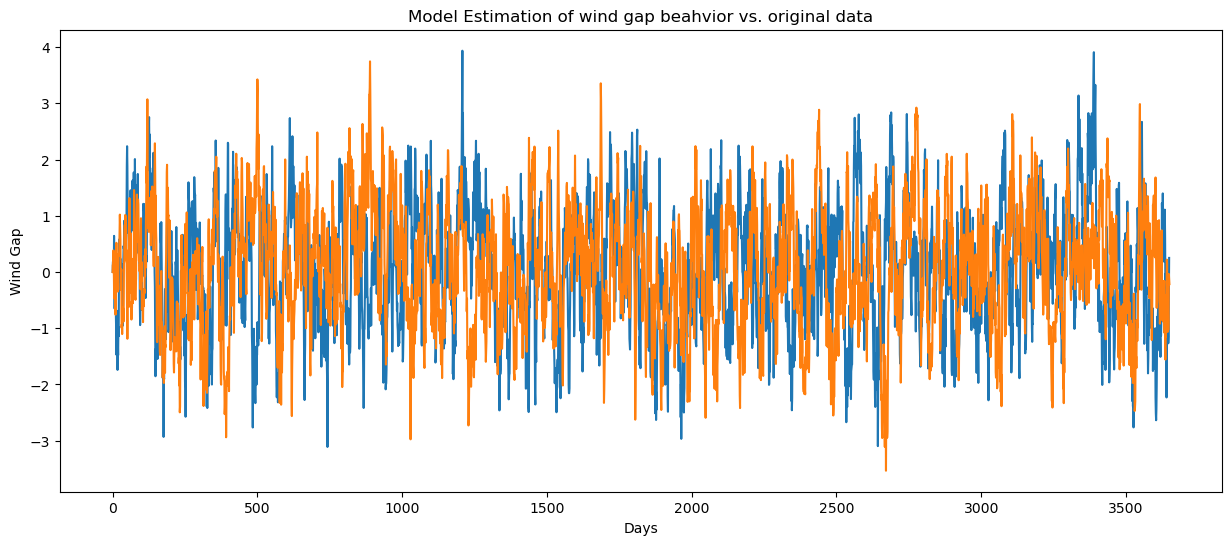

In [382]:
plt.figure(figsize=(15, 6))

# graficar data
plt.plot(data['wind gap norte sur'])


# graficar modelo predicgo
print(beta, gamma)
wind_gap_trip = simulateTrip_windgap(beta, gamma)

plt.plot(wind_gap_trip)
plt.title("Model Estimation of wind gap beahvior vs. original data")
plt.xlabel("Days")
plt.ylabel("Wind Gap")

plt.show()

### Medidas de error para el wind gap

In [383]:
### medidas de error de datos reales

# Convertir los valores reales en un array de numpy para compararlos con los valores simulados
real_wind_gap_values = data["wind gap norte sur"].values

wind_gap_trip_trimmed = np.array(wind_gap_trip[:len(real_wind_gap_values)])

# Calcular los valores máximo y mínimo de la diferencia de viento
wind_gap_max = data["wind gap norte sur"].max()
wind_gap_min = data["wind gap norte sur"].min()

maxima_variacion_WG = wind_gap_max - wind_gap_min

# Calcular la varianza de la diferencia de viento
wind_gap_variance = data["wind gap norte sur"].var()

# Calcular la desviación estándar de la diferencia de viento
wind_gap_std = data["wind gap norte sur"].std()

# Mostrar los resultados
print("Analisis de distribucion de datos reales:")
print(f"Max-Min: [ {wind_gap_min:.2f} , {wind_gap_max:.2f} ]")
print(f"Variacion del viento promeido: {maxima_variacion_WG:.2f}")
print(f"Varianza de la viento promedio: {wind_gap_variance:.2f}")
print(f"Desviación estándar de la viento promeido: {wind_gap_std:.2f}")

### medidas de error entre el modelo y datoss reales

# Calcular los errores entre los valores simulados y los valores reales
errores_WG = real_wind_gap_values - wind_gap_trip_trimmed

# Calcular el RMSE entre los valores simulados y los valores reales
rmse_wind_gap = np.sqrt(mean_squared_error(real_wind_gap_values, wind_gap_trip_trimmed))
# Calcular la varianza del error
varianza_error_WG = np.var(errores_WG)

# Calcular la desviación estándar del error
desviacion_estandar_error_WG = np.std(errores_WG)
# Calcular el MAE

mae_WG = mean_absolute_error(real_wind_gap_values, wind_gap_trip_trimmed)

# Calcular el R^2
r2_WG= r2_score(real_wind_gap_values, wind_gap_trip_trimmed)

# Calcular los errores (residuos)
residuals_WG = data["wind gap norte sur"][:len(wind_gap_trip_trimmed)] - wind_gap_trip_trimmed


# Mostrar los resultados
print("\nAnalisis del modelo:")
print(f"Varianza del error: {varianza_error_WG:.2f}")
print(f"Desviación estándar del error: {desviacion_estandar_error_WG:.2f}")
print(f"RMSE: {rmse_wind_gap:.2f}")
print(f"MAE: {mae_WG:.2f}")
print(f"R²: {r2_WG:.2f}")



Analisis de distribucion de datos reales:
Max-Min: [ -3.11 , 3.94 ]
Variacion del viento promeido: 7.05
Varianza de la viento promedio: 1.13
Desviación estándar de la viento promeido: 1.06

Analisis del modelo:
Varianza del error: 2.22
Desviación estándar del error: 1.49
RMSE: 1.49
MAE: 1.19
R²: -0.97


El modelo parece capturar bien la dinámica de la diferencia de viento entre los molinos, aunque tiene un margen de error moderado.

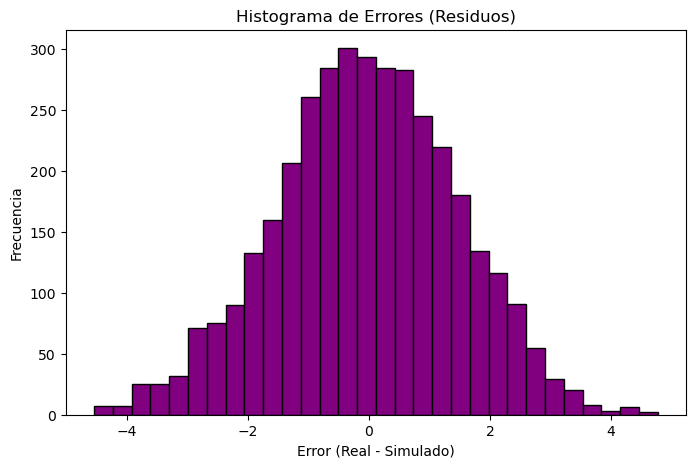

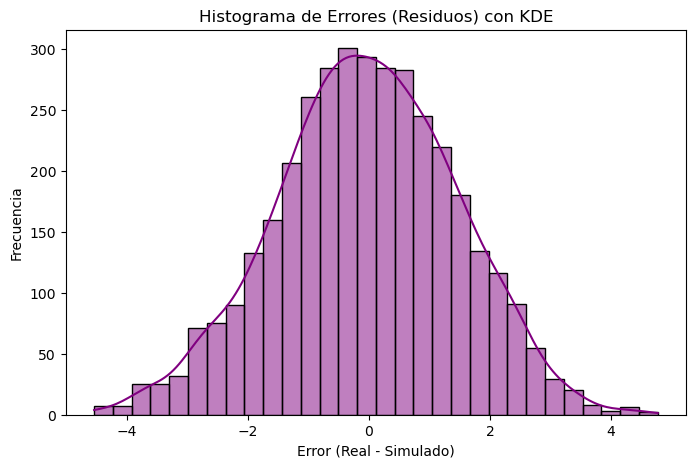

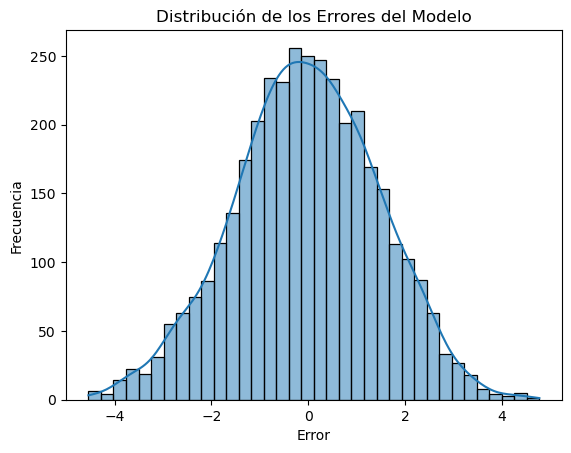

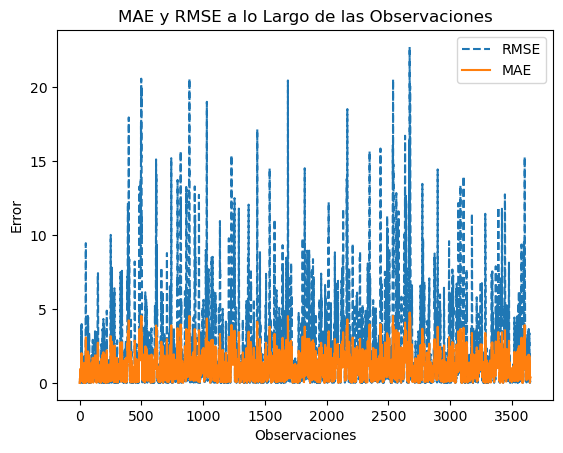

In [384]:

plt.figure(figsize=(8, 5))
plt.hist(residuals_WG, bins=30, color='purple', edgecolor='black')
plt.title('Histograma de Errores (Residuos)')
plt.xlabel('Error (Real - Simulado)')
plt.ylabel('Frecuencia')
plt.show()

# Graficar el histograma con Seaborn
plt.figure(figsize=(8, 5))
sns.histplot(residuals_WG, bins=30, kde=True, color='purple')
plt.title('Histograma de Errores (Residuos) con KDE')
plt.xlabel('Error (Real - Simulado)')
plt.ylabel('Frecuencia')
plt.show()

sns.histplot(errores_WG, kde=True)
plt.title('Distribución de los Errores del Modelo')
plt.xlabel('Error')
plt.ylabel('Frecuencia')
plt.show()

plt.plot(range(len(errores_WG)), errores_WG**2, label='RMSE', linestyle='--')
plt.plot(range(len(errores_WG)), np.abs(errores_WG), label='MAE')

plt.title('MAE y RMSE a lo Largo de las Observaciones')
plt.xlabel('Observaciones')
plt.ylabel('Error')
plt.legend()
plt.show()




Un histograma centrado alrededor de 0 sugiere que los errores están bien distribuidos y que el modelo está funcionando correctamente.


# 2

## Simulacion simultanea de molinos (norte y sur) con M caminos

In [385]:
def simulacion(kappa, sigma,beta,gamma, dias = N, M = 100,seed = 0):
# m = cantidad de caminos
# simula n dias de los m molinos 
    if(seed != 0):
        np.random.seed(seed)
    molinoNorte, molinoSur, diff = np.zeros((M, dias)), np.zeros((M, dias)), np.zeros((M, dias))
    Z,W = np.random.normal(0, 1, (M, dias)), np.random.normal(0, 1, (M, dias))

    
    molinoNorte[:,0] = S0
    diff[:,0] = D0

    for t in range(1, dias):
        molinoNorte[:,t] = molinoNorte[:, t-1] + kappa * (theta(np.zeros(M) + t) - molinoNorte[:, t-1]) * DELTA + np.sqrt(DELTA) * Z[:,t] * sigma
        diff[:,t] = diff[:, t-1] - beta * diff[:, t-1] * DELTA + np.sqrt(DELTA) * W[:,t] * gamma
        molinoSur[:,t] = molinoNorte[:,t] + diff[:,t]
    return molinoNorte , molinoSur   

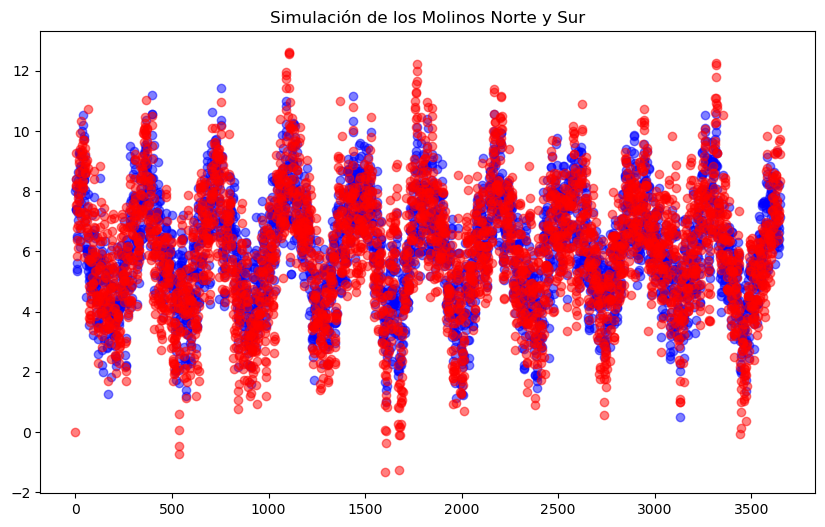

In [386]:
M = 50
simulations = simulacion(kappa, sigma,beta,gamma,dias= N, M=M)

plt.figure(figsize=(10, 6))
# Scatter plot
plt.scatter(range(N), simulations[0][0], label='Molino Norte', color='blue', alpha=0.5)
plt.scatter(range(N), simulations[1][0], label='Molino Sur', color='red', alpha=0.5)
plt.title('Simulación de los Molinos Norte y Sur')
plt.show()

### Grafico

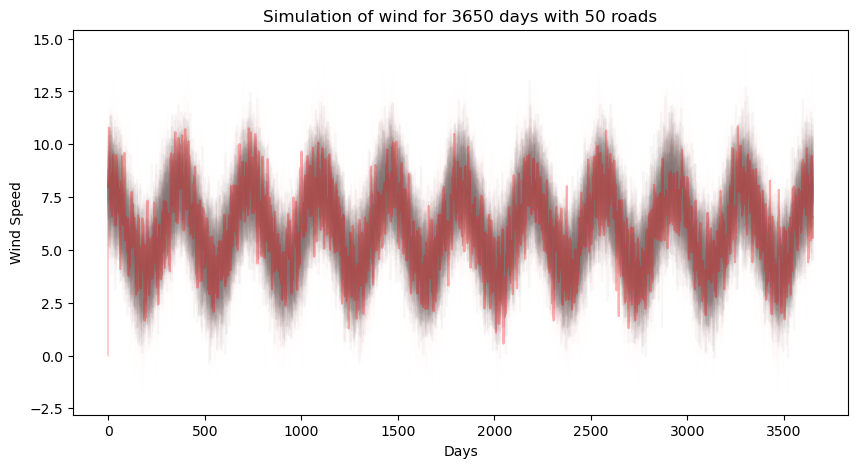

In [387]:
# Plot simulation
plt.figure(figsize=(10, 5))

for i in range(M):
    # color gray and alpha 0.1
    plt.plot(simulations[0][i,:], color='gray', alpha=0.05)
    plt.plot(simulations[1][i,:], color='red', alpha=0.005)

plt.plot(data['regional wind'],color="red", alpha=0.3)
plt.title(f"Simulation of wind for {N} days with {M} roads")
plt.xlabel("Days")
plt.ylabel("Wind Speed")
plt.show()

### Promedio de todos los cmainos para verificar que se acerca a la data historica + error o varianza de este promedio como medidas de seguirdad

RMSE for Simulated Average Wind: 1.20


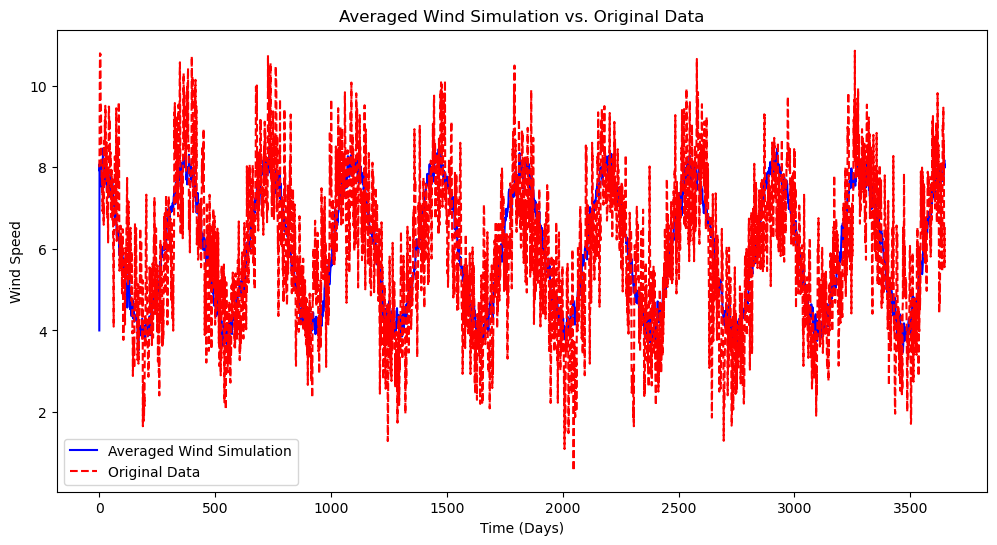

In [388]:
## corregir

# Average the simulations
avg_molinoNorte = np.mean(simulations[0], axis=0)
avg_molinoSur = np.mean(simulations[1], axis=0)

# Average wind speed (combine average Norte and Sur)
average_wind_simulation = (avg_molinoNorte + avg_molinoSur) / 2

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(data['regional wind'], average_wind_simulation))

print(f"RMSE for Simulated Average Wind: {rmse:.2f}")

# Plot the averaged simulation
plt.figure(figsize=(12, 6))

plt.plot(average_wind_simulation, label='Averaged Wind Simulation', color='blue')
plt.plot(data['regional wind'], label='Original Data', color='red', linestyle='--')
plt.title('Averaged Wind Simulation vs. Original Data')
plt.xlabel('Time (Days)')
plt.ylabel('Wind Speed')
plt.legend()
plt.show()

RMSE for Simulated Average Wind: 1.19
Variance of the error: 1.43


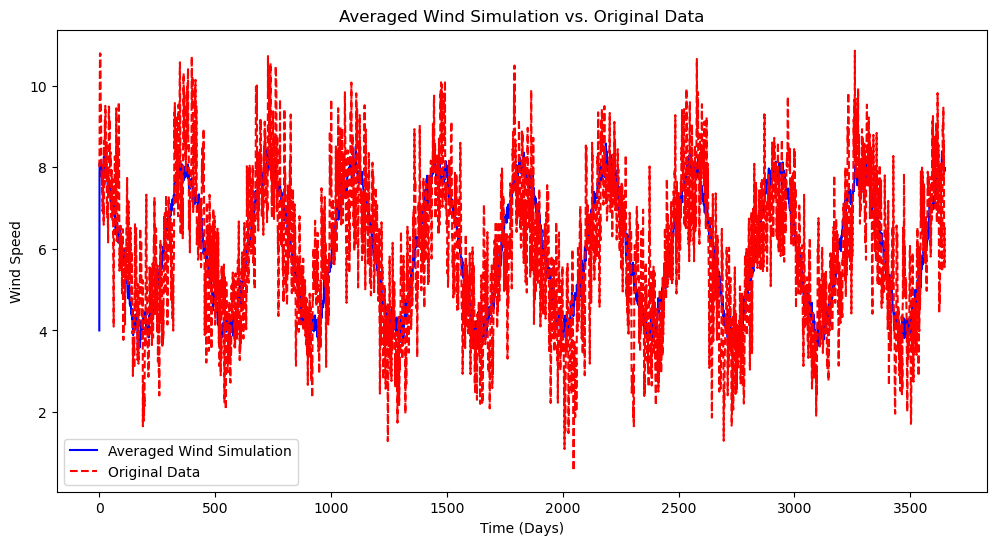

In [389]:
### chat gpt 


# Simulación
simulations = simulacion(kappa, sigma, beta, gamma, dias=N, M=M)

# Promediar las simulaciones en el tiempo
avg_molinoNorte = np.mean(simulations[0], axis=0)
avg_molinoSur = np.mean(simulations[1], axis=0)

# Promediar los molinos Norte y Sur para obtener la simulación promedio
average_wind_simulation = (avg_molinoNorte + avg_molinoSur) / 2

# Asegúrate de que la longitud del vector de simulación coincida con los datos reales
average_wind_simulation = average_wind_simulation[:len(data['regional wind'])]

# Calcular el RMSE
rmse = np.sqrt(mean_squared_error(data['regional wind'], average_wind_simulation))

# Calcular la varianza del error entre simulación y datos reales
errores = data['regional wind'] - average_wind_simulation
varianza_error = np.var(errores)

# Mostrar el RMSE y la varianza del error
print(f"RMSE for Simulated Average Wind: {rmse:.2f}")
print(f"Variance of the error: {varianza_error:.2f}")

# Graficar la simulación promedio y los datos originales
plt.figure(figsize=(12, 6))
plt.plot(average_wind_simulation, label='Averaged Wind Simulation', color='blue')
plt.plot(data['regional wind'], label='Original Data', color='red', linestyle='--')
plt.title('Averaged Wind Simulation vs. Original Data')
plt.xlabel('Time (Days)')
plt.ylabel('Wind Speed')
plt.legend()
plt.show()


## Ganancia con la expecion de roturas y prendido y apagado del molino consideradas

### Constantes

In [390]:
# el ingreso diario generado es 1000 ∗ Si dolares si el molino esta prendido ese dia
PRICE = 1000
# La probabilidad de que el molino se rompa en el dia i, si estaba activo en el dia i −1, es 0.25 ∗ S(i)2∆.
BREAK_PROB = 0.25
# Si el molino falla un dıa, ese dia no estara activo y se arreglara el mismo dıa a un costo de 200 mil dolares
BREAK_COST = 200000
# El acto de apagar el molino cuesta 1000 dolares cada vez. Prenderlo no cuesta nada.
TURN_OFF_COST = 1000
TURN_ON_COST = 0
# La tasa de inter ́es es del 5% anual con capitalizacion diaria (el cashflow en dia i se descuenta como e−0.05i/365)
INTEREST_RATE = 0.05

POWER_GENERATION = 100  # Generación de energía por día cuando está en funcionamiento
PRICE_PER_KWH = 0.05  # Precio por kWh


### Funciones Utiles

In [391]:

def proba_romperse(S):
    return BREAK_PROB * np.array(S) ** 2 * DELTA

def inversa_proba_romperse(p):
    return np.sqrt( p / (BREAK_PROB*DELTA))

def ingreso(S:List[float], isOn:List[bool],seRompio:List[bool]):
    break_cost = BREAK_COST * np.logical_and(isOn,seRompio)
    return PRICE * np.array(S) * np.logical_and(isOn,np.logical_not(np.array(seRompio)))  - break_cost


def nextStateIsOn(S:List[float], isOn:List[bool],k): #     TT , TF , FT , FF
    turn_off_candidate = np.array(S) >= k
    prender = ~np.logical_and(isOn , turn_off_candidate)# TT = 0, TF = 0, FT = 0, FF = 1
    apagar = np.logical_and(isOn , turn_off_candidate)  # TT = 1, TF = 0, FT = 0, FF = 0

    costo_prender_total = prender * TURN_ON_COST
    costo_apagar_total = apagar * TURN_OFF_COST

    nextIsOn = ~turn_off_candidate
    
    return nextIsOn, costo_prender_total + costo_apagar_total

def seRompio(S:List[float],isOn:List[bool]):
    return np.logical_and(np.random.uniform(0,1,size=(np.array(S).shape)) < proba_romperse(S),isOn)



### Probabilidad de romperse

Total area under the curve where breakage probability is less than 0.5: 4.49


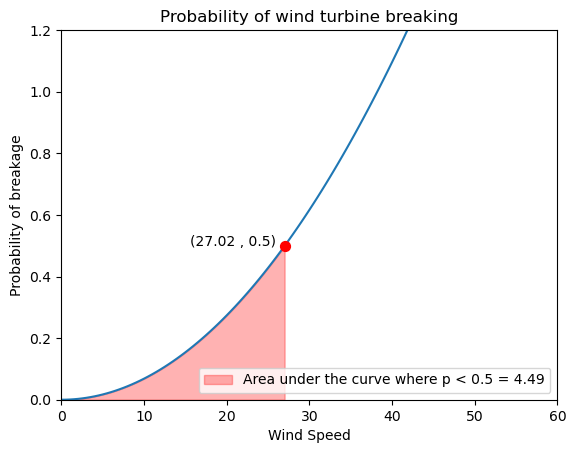

In [392]:
S = np.arange(0,60,0.5)
p = proba_romperse(S)

threshold_prob = 0.5
viento_threshold = inversa_proba_romperse(threshold_prob)
plt.plot(S,p)
plt.title("Probability of wind turbine breaking")
plt.xlabel("Wind Speed")
plt.ylabel("Probability of breakage")

# Calculate the area under the curve where the breakage probability exceeds the threshold
mask = p <= threshold_prob


# Calculate the area under the curve where the breakage probability exceeds the threshold

area_under_curve = simpson(y=p[mask], x=S[mask])

print(f"Total area under the curve where breakage probability is less than {threshold_prob}: {area_under_curve:.2f}")


# Add more space between the point and the text (adjusting the position slightly)
#plt.text(39.85, 0.989, f'(38.21 , 1.00)', fontsize=10, ha='left')

#plt.axhline(threshold_prob, color='red', linestyle='--', label=f"Threshold Probability = {0.5}")

# Mark the specific point

plt.scatter(viento_threshold, threshold_prob, color='red', s=50, zorder=5)
plt.text(viento_threshold - 1, threshold_prob, f'({round(viento_threshold,2)} , {threshold_prob})', fontsize=10, ha='right')
#plt.axvline(27.03, color='green', linestyle='--', label=f"Break Point ≈ {27.03:.2f} m/s")

# Shade the area under the curve where probability exceeds the threshold
plt.fill_between(S, 0, p, where=(p <= threshold_prob), color='red', alpha=0.3, label = f"Area under the curve where p < {threshold_prob} = {area_under_curve:.2f}")
plt.legend()
plt.ylim(0,1.2)
plt.xlim(0,60)
plt.show()

In [393]:
def ganancia(molinoNorte, molinoSur,k,seed=0):
    """M simulaciones de molino norte y M simulaciones de molino sur y n dias para cada simulacion, k el umbral elegido 
    
    """
    if seed != 0:
        np.random.seed(seed)
    #si el molino esta prendido en el dia i
    isOnNorte = np.zeros_like(molinoNorte) + 1
    isOnSur   = np.zeros_like(molinoSur) + 1

    #calculamos dia a dia ganancia acumulada
    gananciaNorte = np.zeros_like(molinoNorte)
    gananciaSur = np.zeros_like(molinoSur)

    #si hay una rotura en el dia i, independiente a prendido o apagado
    roturaNorte = np.zeros_like(molinoNorte)
    roturaSur = np.zeros_like(molinoSur)
    
    # recorremos dia a dia 
    for t in range(1,molinoNorte.shape[1]-1):
        #para el norte:
        #chequeamos si ayer estuvo prendido o apagado segun el viento de hoy 
        #me fijo si hoy se rompio (viento de hoy + prendido y apagado)
        #calculamos el ingreso(viento + prendido si esta roto)
        #maximizamos beneficios 
        isOnNorte[:,t],costosNorte_t = nextStateIsOn(molinoNorte[:,t],isOnNorte[:,t-1],k)
        roturaNorte[:,t] = seRompio(molinoNorte[:,t],isOnNorte[:,t])
        ingresoNorte_t = ingreso(molinoNorte[:,t],isOnNorte[:,t],roturaNorte[:,t])
        gananciaNorte[:,t] =  gananciaNorte[:,t-1] + ingresoNorte_t - costosNorte_t

        #para el sur:
        isOnSur[:,t],costosSur_t = nextStateIsOn(molinoSur[:,t],isOnSur[:,t-1],k)
        roturaSur[:,t] = seRompio(molinoSur[:,t],isOnSur[:,t])
        ingresoSur_t = ingreso(molinoSur[:,t],isOnSur[:,t],roturaSur[:,t])
        gananciaSur[:,t] = gananciaSur[:,t-1] +  ingresoSur_t - costosSur_t
        
    
    return gananciaNorte, gananciaSur, isOnNorte, isOnSur, roturaNorte, roturaSur

### VAN

In [394]:
#INTEREST_RATE = 0.05  # tasa de interés de ejemplo

def van(ganancia,cumSum:bool=True):
    dia_a_dia = np.diff(ganancia, axis=1)
    # print(dia_a_dia.shape)
    tasaDescuento = [np.exp(-INTEREST_RATE * i / 365) for i in range(dia_a_dia.shape[1])]
    if cumSum:
        return np.cumsum(dia_a_dia * tasaDescuento, axis=1)
    else:
        return dia_a_dia * tasaDescuento

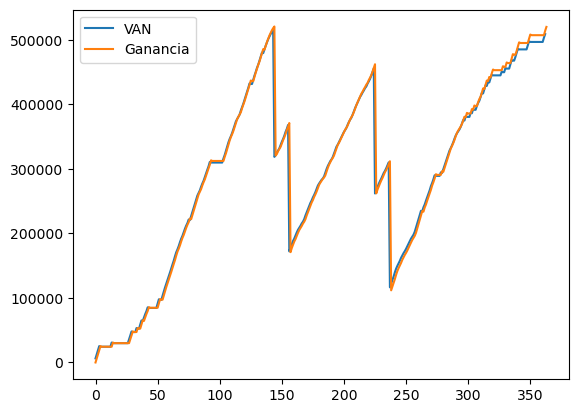

VAN Norte: -2092.93
VAN Sur: 16194.85
VAN total = 14101.92


In [395]:
m = 50
n = 365 
K = 15

simulations = simulacion(kappa, sigma,beta,gamma,dias= n, M=m)
gananciaNorte, gananciaSur, isOnNorte,isOnSur, roturaNorte, roturaSur = ganancia(simulations[0],simulations[1],7)


van_norte = van(gananciaNorte)
van_sur = van(gananciaSur)

#plot
plt.plot(van_norte[0][:-1])
plt.plot(gananciaNorte[0][:-1])
plt.legend(["VAN","Ganancia"])
plt.show()



print(f"VAN Norte: {round(van_norte[-1][-1],2)}")
print(f"VAN Sur: {round( van_sur[-1][-1], 2)}")
print(f"VAN total = {round(van_norte[-1][-1] + van_sur[-1][-1], 2)}")


# 3

### Implementa una simulacion para la evolucion simultanea del viento en cada molino, las roturas, las decisiones de apagado y encendido, y la acumulacion de cashflows enel tiempo.

In [396]:
m = 200
n = 365 
K = 15
seed = 10
simulations = simulacion(kappa, sigma,beta,gamma,dias= n, M=m)
# gananciaNorte, gananciaSur, isOnNorte,isOnSur, roturaNorte, roturaSur = ganancia(simulations[0],simulations[1],5)
gananciaNorteI = [[ganancia(simulations[0],simulations[1],k,seed)[0],ganancia(simulations[0],simulations[1],k,seed)[2],ganancia(simulations[0],simulations[1],k,seed)[4]] for k in np.arange(0,K,1)]
print(gananciaNorteI[5][0].shape,gananciaNorteI[5][1].shape,gananciaNorteI[5][2].shape)
gananciaPromedio = np.array([np.mean(gananciaNorteI[k][0][:,-2]) for k in range(len(gananciaNorteI))])
gananciaVarianza = np.array([np.var(gananciaNorteI[k][0][:,-2]) for k in range(len(gananciaNorteI))])
gananciaStd = np.array([np.std(gananciaNorteI[k][0][:,-2]) for k in range(len(gananciaNorteI))])

color = np.array(gananciaNorteI) 

(200, 365) (200, 365) (200, 365)


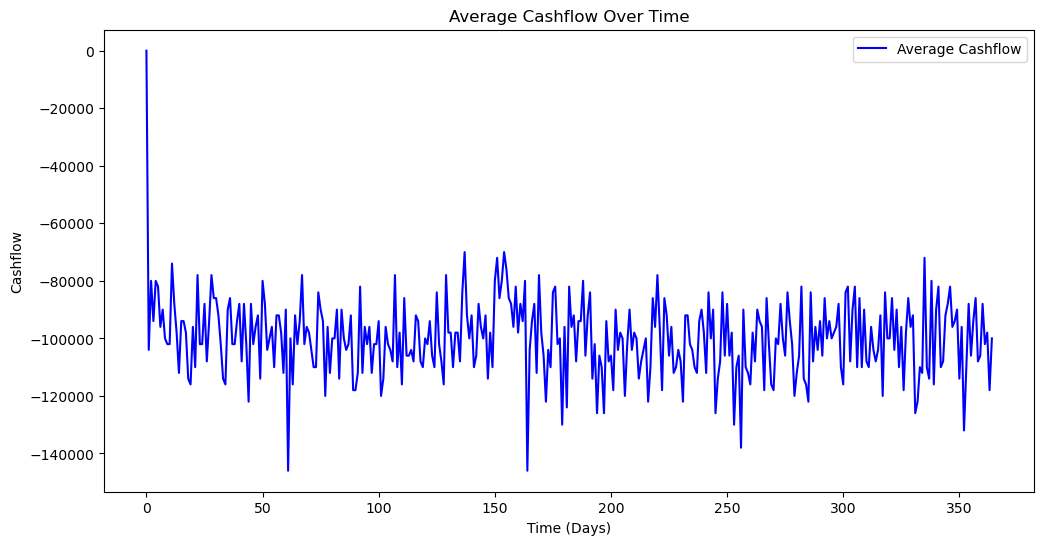

In [397]:
## chat gpt 

# Parámetros de simulación
N = 365  # Número de días para la simulación
M = 100  # Número de caminos simulados
seed = 42


# Función para simular el viento y el cashflow
def simulacionEmily(kappa, sigma, beta, gamma, dias=N, M=M, seed=seed):
    np.random.seed(seed)
    molinoNorte, molinoSur = np.zeros((M, dias)), np.zeros((M, dias))
    Z, W = np.random.normal(0, 1, (M, dias)), np.random.normal(0, 1, (M, dias))
    roturaNorte, roturaSur = np.zeros((M, dias)), np.zeros((M, dias))
    cashflow = np.zeros((M, dias))
    
    molinoNorte[:,0] = S0
    molinoSur[:,0] = S0
    diff = np.zeros((M, dias))
    diff[:,0] = D0

    for t in range(1, dias):
        # Simulación del viento
        molinoNorte[:,t] = molinoNorte[:, t-1] + kappa * (theta(np.zeros(M) + t) - molinoNorte[:, t-1]) * DELTA + np.sqrt(DELTA) * Z[:,t] * sigma
        diff[:,t] = diff[:, t-1] - beta * diff[:, t-1] * DELTA + np.sqrt(DELTA) * W[:,t] * gamma
        molinoSur[:,t] = molinoNorte[:,t] + diff[:,t]
        
        # Simulación de roturas
        roturaNorte[:,t] = np.random.binomial(1, BREAK_PROB, M)
        roturaSur[:,t] = np.random.binomial(1, BREAK_PROB, M)
        
        # Decisiones de apagado/encendido
        funcionamientoNorte = (roturaNorte[:,t] == 0) & (molinoNorte[:,t] > 0)  # Apagado si está roto o viento negativo
        funcionamientoSur = (roturaSur[:,t] == 0) & (molinoSur[:,t] > 0)
        
        # Cashflow
        ingresosNorte = funcionamientoNorte * POWER_GENERATION * PRICE_PER_KWH
        ingresosSur = funcionamientoSur * POWER_GENERATION * PRICE_PER_KWH
        costosNorte = roturaNorte[:,t] * BREAK_COST
        costosSur = roturaSur[:,t] * BREAK_COST
        
        cashflow[:,t] = ingresosNorte + ingresosSur - costosNorte - costosSur

    return molinoNorte, molinoSur, cashflow

# Ejecutar la simulación
molinoNorte, molinoSur, cashflow = simulacionEmily(kappa, sigma, beta, gamma, dias=N, M=M)

# Promediar los resultados
avg_cashflow = np.mean(cashflow, axis=0)

# Graficar resultados
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(avg_cashflow, label='Average Cashflow', color='blue')
plt.title('Average Cashflow Over Time')
plt.xlabel('Time (Days)')
plt.ylabel('Cashflow')
plt.legend()
plt.show()


### Graficos 

In [398]:

def plot_sine(a,b):
    prndido_y_roto = np.logical_and(gananciaNorteI[a][1][b,:],gananciaNorteI[a][2][b,:])
    # print("Cant rompimientos: ",sum(prndido_y_roto[7]))
    #                           isOn                              seRompio
    color = np.array(1+-(gananciaNorteI[a][1][b,:]) +  gananciaNorteI[a][2][b,:]  + prndido_y_roto) 
    # change value 3 to 1 if isOn
    # color = np.where(color == 3, 1, color)

    plt.figure(figsize=(10,5))
    plt.yticks([])
    plt.scatter(range(simulations[0].shape[1]-2),simulations[0][b,1:-1],c=color[1:-1],cmap='coolwarm_r',alpha=0.5)
    # plot threshold k
    plt.axhline(a, color='orange')
    plt.show()
    plt.figure(figsize=(10,5))
    plt.yticks([])
    for i in range(m):
        # plot text
        if i == b:
            plt.plot(gananciaNorteI[a][0][i,:-1],color='red',alpha=0.5)
        else:
            plt.plot(gananciaNorteI[a][0][i,:-1],color='gray',alpha=0.05)

    # plot ganancia promedio
    plt.axhline(0, color='black')
    plt.plot(np.mean(gananciaNorteI[a][0][:,:-1],axis=0),color='black',alpha=0.9)
    # plt.text(0, 2000.0, "Ganancia del año: " + str(np.mean(gananciaNorteI[a][0][:,-2],axis=0)), fontsize=20)

    plt.show()

    # plot ganancia promedio
    plt.figure(figsize=(10,5))
    # plt.ylim(-150000,1500000)
    plt.plot(np.sum(gananciaPromedio))
    plt.axhline(0, color='black')
    # plot ganancia promedio + desviacion estandar
    plt.plot(gananciaPromedio, color='blue')
    # plt.plot(gananciaPromedio + (gananciaVarianza / len(gananciaVarianza))**0.5, color='gray',alpha=0.63)
    # plt.plot(gananciaPromedio - (gananciaVarianza / len(gananciaVarianza))**0.5, color='gray',alpha=0.63)
    # plt.plot(gananciaPromedio + (2*gananciaVarianza / len(gananciaVarianza))**0.5, color='gray',alpha=0.33)
    # plt.plot(gananciaPromedio - (2*gananciaVarianza / len(gananciaVarianza))**0.5, color='gray',alpha=0.33)

    plt.fill_between(range(K), gananciaPromedio - 1.97 * (gananciaVarianza / len(gananciaVarianza))**0.5, gananciaPromedio + 1.97 * (gananciaVarianza / len(gananciaVarianza))**0.5, color='gray')
    # plt.fill_between(range(K), gananciaPromedio - (2*gananciaVarianza / len(gananciaVarianza))**0.5, gananciaPromedio + (2*gananciaVarianza / len(gananciaVarianza))**0.5, color='gray')
    plt.axvline(a, color='red')
    plt.show()

    
# Crear un slider interactivo usando ipywidgets

interact(plot_sine, a=widgets.IntSlider(min=0, max=K-1, step= 1, value=7), b=widgets.IntSlider(min=0, max=m-1, step= 1, value=0))


interactive(children=(IntSlider(value=7, description='a', max=14), IntSlider(value=0, description='b', max=199…

<function __main__.plot_sine(a, b)>

# 4. junto con un camino t ́ıpico del viento simulado grafic ́a la evoluci ́on contempor ́anea
del estado de cada molino (momentos en que est ́a activo / inactivo, momentos en los
que se rompi ́o, etc). Tiene sentido lo que ves?

In [ ]:
m = 1
dias = 365
kappa = kappa  
sigma = sigma  
beta = beta  
gamma = gamma

simulated_molinoNorte, simulated_molinoSur = simulacion(kappa, sigma, beta, gamma, dias=dias, M=m)

k = 7
gananciaNorte, gananciaSur, isOnNorte, isOnSur, roturaNorte, roturaSur = ganancia(simulated_molinoNorte, simulated_molinoSur, k, 10)

fig, axs = plt.subplots(2, 1, figsize=(14, 12), sharex=True)

# Datos del Molino Norte
axs[0].plot(simulated_molinoNorte[0], color='blue', label='Velocidad del Viento', linewidth=2)
axs[0].fill_between(np.arange(dias), 0, np.where(isOnNorte[0], simulated_molinoNorte[0], 0), color='red', alpha=0.3, label='Molino Norte Activo')
axs[0].vlines(np.where(roturaNorte[0])[0], 0, np.max(simulated_molinoNorte[0]), color='red', linestyle='dotted', linewidth=1.5, label='Rotura Molino Norte')
axs[0].set_title('Comportamiento del Molino Norte', fontsize=16)
axs[0].set_ylabel('Velocidad del Viento (m/s)', fontsize=14)
axs[0].legend(loc='upper right', fontsize=12)
axs[0].grid(True, which='both', linestyle='--', alpha=0.5)

# Datos del Molino Sur
axs[1].plot(simulated_molinoSur[0], color='blue', label='Velocidad del Viento', linewidth=2)
axs[1].fill_between(np.arange(dias), 0, np.where(isOnSur[0], simulated_molinoSur[0], 0), color='green', alpha=0.3, label='Molino Sur Activo')
axs[1].vlines(np.where(roturaSur[0])[0], 0, np.max(simulated_molinoSur[0]), color='orange', linestyle='dotted', linewidth=1.5, label='Rotura Molino Sur')
axs[1].set_title('Comportamiento del Molino Sur', fontsize=16)
axs[1].set_xlabel('Días', fontsize=14)
axs[1].set_ylabel('Velocidad del Viento (m/s)', fontsize=14)
axs[1].legend(loc='upper right', fontsize=12)
axs[1].grid(True, which='both', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# 5. A partir de un n ́umero suficientemente grande de caminos calcula el VAN esperado
de tus molinos como funci ́on del umbral de apagado y encendido. Acompa ̃na este y
otros estimadores con medidas de error est ́andar

In [ ]:
resultados_van_norte = []
resultados_van_sur = []

m = 10000
kappa = kappa
sigma = sigma
beta = beta
gamma = gamma
dias = 365

for umbral in range(1, 14):
    simulations = simulacion(kappa, sigma, beta, gamma, dias=dias, M=m)
    gananciaNorte, gananciaSur, _, _, _, _ = ganancia(simulations[0], simulations[1], umbral, 10)

    van_norte = van(gananciaNorte)
    van_sur = van(gananciaSur)
    
    van_esperado_norte = np.mean(van_norte)
    error_std_norte = (np.std(van_norte, ddof=0)/np.sqrt(len(van_norte))) * 1.96

    van_esperado_sur = np.mean(van_sur)
    error_std_sur = (np.std(van_sur, ddof=1)/np.sqrt(len(van_sur))) * 1.96

    resultados_van_norte.append((umbral, van_esperado_norte, error_std_norte))
    resultados_van_sur.append((umbral, van_esperado_sur, error_std_sur))

umbrales_norte, van_esperado_norte, error_std_norte = zip(*resultados_van_norte)
umbrales_sur, van_esperado_sur, error_std_sur = zip(*resultados_van_sur)

plt.figure(figsize=(12, 6))

plt.errorbar(umbrales_norte, van_esperado_norte, yerr=error_std_norte, label='Molino Norte', color='red', fmt='-o')
plt.errorbar(umbrales_sur, van_esperado_sur, yerr=error_std_sur, label='Molino Sur', color='green', fmt='-o')

plt.xlabel('Umbral de Apagado/Encendido')
plt.ylabel('VAN Esperado')
plt.title('VAN Esperado vs. Umbral con Error Estándar')
plt.legend()
plt.grid(True)

plt.show()

# 6. Cu ́al es el valor  ́optimo para el umbral de apagado y encendido, o sea, que maximiza el valor actual neto de cashflows generados durante un a ̃no?


In [ ]:
higher_van = -100000000
best_umbral = 0
best_error = 0

for i in range(len(van_esperado_norte)):
    van_norte = van_esperado_norte[i]
    van_sur = van_esperado_sur[i]

    van_esperado = van_norte + van_sur

    if van_esperado >= higher_van:
        higher_van = van_esperado
        best_umbral = umbrales_norte[i]

print(higher_van, best_umbral)

In [ ]:
plt.figure(figsize=(12, 6))

plt.errorbar(umbrales_norte, van_esperado_norte, yerr=error_std_norte, label='Molino Norte', color='red', fmt='-o')
plt.errorbar(umbrales_sur, van_esperado_sur, yerr=error_std_sur, label='Molino Sur', color='green', fmt='-o')

plt.axvline(x=best_umbral, color='yellow', linestyle='--', label='Umbral Óptimo')

plt.xlabel('Umbral de Apagado/Encendido')
plt.ylabel('VAN Esperado')
plt.title('VAN Esperado vs. Umbral con Error Estándar')
plt.legend()
plt.grid(True)

plt.show()

# 7. Cu ́anto es la ganancia de VAN en este caso vs la operaci ́on ingenua que nunca
apaga los molinos?

In [ ]:
umbral_ingenuo = 9999  # Un valor suficientemente alto para no apagar nunca

simulacion_ingenua = simulacion(kappa, sigma, beta, gamma, dias=dias, M=m)
gananciaNorte_ingenua, gananciaSur_ingenua, _, _, _, _ = ganancia(simulacion_ingenua[0], simulacion_ingenua[1], umbral_ingenuo, 10)

van_norte_ingenua = van(gananciaNorte_ingenua)
van_sur_ingenua = van(gananciaSur_ingenua)

van_esperado_norte_ingenua = np.mean(van_norte_ingenua)
error_std_norte_ingenua = (np.std(van_norte_ingenua, ddof=1) / np.sqrt(len(van_norte_ingenua))) * 1.96

van_esperado_sur_ingenua = np.mean(van_sur_ingenua)
error_std_sur_ingenua = (np.std(van_sur_ingenua, ddof=1) / np.sqrt(len(van_sur_ingenua))) * 1.96

van_esperado_ingenuo = van_esperado_norte_ingenua + van_esperado_sur_ingenua
error_std_ingenuo = np.sqrt(error_std_norte_ingenua*2 + error_std_sur_ingenua*2)

print(f"VAN Esperado Ingenuo: {van_esperado_ingenuo:.2f}")
print(f"Error Estándar Ingenuo: {error_std_ingenuo:.2f}")
print(f"Diferencia de VAN optimizando el umbral vs. no optimizandolo: {(higher_van - van_esperado_ingenuo):.2f}")

# 8. Si considero al ingreso total durante el mes de agosto (sin descontar) como una
variable aleatoria, cu ́al es su distribuci ́on bajo el umbral de operaci ́on  ́optimo?

In [ ]:
dias_agosto = list(range(213, 244))

umbral_optimo = best_umbral

m = 20000

simulations = simulacion(kappa, sigma, beta, gamma, dias=365, M=m)
gananciaNorte, gananciaSur, _, _, _, _ = ganancia(simulations[0], simulations[1], umbral_optimo, seed=None)

ingreso_agosto_norte = np.sum(gananciaNorte[:, dias_agosto], axis=1)
ingreso_agosto_sur = np.sum(gananciaSur[:, dias_agosto], axis=1)

ingresos_agosto = ingreso_agosto_norte + ingreso_agosto_sur

plt.hist(ingresos_agosto, bins=30, edgecolor='black', alpha=0.7)
plt.title("Distribución del Ingreso Total en Agosto (Simulaciones)")
plt.xlabel("Ingreso Total")
plt.ylabel("Frecuencia")
plt.show()

media_agosto = np.mean(ingresos_agosto)
desviacion_estandar_agosto = (np.std(ingresos_agosto)/ np.sqrt(m)) * 1.96
print(f"Ingreso Medio en Agosto: {media_agosto}")
print(f"Desviación Estándar del Ingreso en Agosto: {desviacion_estandar_agosto}")

# 9. Cual es el numero medio de roturas por año que sufre el molino bajo la estrategia optima y cuantas si no se lo apaga nunca?

In [399]:
# Suponiendo que la estrategia optime es con el umbral 'k' en 7

roturasNorteI = [[ganancia(simulations[0],simulations[1],k,seed)[4]] for k in [7,14]]
roturasSurI = [[ganancia(simulations[0],simulations[1],k,seed)[5]] for k in [7,17]]
print(np.array(roturasNorteI[0][0]).shape)
print(np.mean(np.sum(np.array(roturasNorteI[0][0]),axis=1)))
# Numero de roturas Promedio
print("Numero de roturas del molino Norte promedio en el año con k=7:",np.mean(np.sum(np.array(roturasNorteI[0][0]),axis=1)))
print("Numero de roturas del molino Norte promedio en el año con k=14:",np.mean(np.sum(np.array(roturasNorteI[1][0]),axis=1)))

print("\nNumero de roturas del molino Sur promedio en el año con k=7:",np.mean(np.sum(np.array(roturasSurI[0][0]),axis=1)))
print("Numero de roturas del molino Sur promedio en el año con k=14:",np.mean(np.sum(np.array(roturasSurI[1][0]),axis=1)))

print("\nNumero de roturas del promedio total en el año con k=7:",np.mean(np.sum(np.array(roturasNorteI[0][0]),axis=1))*0.5 + np.mean(np.sum(np.array(roturasSurI[0][0]),axis=1))*0.5)
print("Numero de roturas del promedio total en el año con k=14:",np.mean(np.sum(np.array(roturasNorteI[1][0]),axis=1))*0.5 + np.mean(np.sum(np.array(roturasSurI[1][0]),axis=1))*0.5)

(200, 365)
5.03
Numero de roturas del molino Norte promedio en el año con k=7: 5.03
Numero de roturas del molino Norte promedio en el año con k=14: 10.0

Numero de roturas del molino Sur promedio en el año con k=7: 4.01
Numero de roturas del molino Sur promedio en el año con k=14: 9.615

Numero de roturas del promedio total en el año con k=7: 4.52
Numero de roturas del promedio total en el año con k=14: 9.807500000000001


# 10. Bajo la estrategia optima, cual es el numero de dıas por año en los que cada molino esta inactivo en promedio, ya sea por apagado voluntario o rotura?

In [400]:
# TODO: Hay que restar los dias rotos de los dias prendidos para obtener el numero de dias efectivos

# Suponiendo que la estrategia optime es con el umbral 'k' en 7


isOnNorteI = [[ganancia(simulations[0],simulations[1],k,seed)[2]] for k in [7,14]]
isOnSurI = [[ganancia(simulations[0],simulations[1],k,seed)[3]] for k in [7,17]]
print(np.array(roturasNorteI[0][0]).shape)
print(np.mean(np.sum(np.array(roturasNorteI[0][0]),axis=1)))
# Numero de roturas Promedio
print("Numero de dias prendido del molino Norte promedio en el año con k=7:",np.mean(np.sum(np.array(isOnNorteI[0][0]),axis=1)))
print("Numero de dias prendido del molino Norte promedio en el año con k=14:",np.mean(np.sum(np.array(isOnNorteI[1][0]),axis=1)))

print("\nNumero de dias prendido del molino Sur promedio en el año con k=7:",np.mean(np.sum(np.array(isOnSurI[0][0]),axis=1)))
print("Numero de dias prendido del molino Sur promedio en el año con k=14:",np.mean(np.sum(np.array(isOnSurI[1][0]),axis=1)))

print("\nNumero de roturas del promedio total en el año con k=7:",np.mean(np.sum(np.array(isOnNorteI[0][0]),axis=1))*0.5 + np.mean(np.sum(np.array(isOnSurI[0][0]),axis=1))*0.5)
print("Numero de roturas del promedio total en el año con k=14:",np.mean(np.sum(np.array(isOnNorteI[1][0]),axis=1))*0.5 + np.mean(np.sum(np.array(isOnSurI[1][0]),axis=1))*0.5)

(200, 365)
5.03
Numero de dias prendido del molino Norte promedio en el año con k=7: 252.935
Numero de dias prendido del molino Norte promedio en el año con k=14: 365.0

Numero de dias prendido del molino Sur promedio en el año con k=7: 248.955
Numero de dias prendido del molino Sur promedio en el año con k=14: 365.0

Numero de roturas del promedio total en el año con k=7: 250.945
Numero de roturas del promedio total en el año con k=14: 365.0


# 11. Cual es la probabilidad de que los dos molinos est ́en inactivos el 9 de julio? Y en algun dıa del año?

# 12. Cual es la correlacion entre los ingresos totales mensuales de mayo de los dos molinos?

In [411]:
M = 10000
seed = 42
days = 365
# Lee el archivo de Excel
data = pd.read_excel("Wind data for TP1.xlsx")

mayo_datos = data[(data['dia'] >= 121) & (data['dia'] <= 152)]

simus = simulacion(kappa, sigma, beta, gamma, dias = days, M = M, seed= seed)

print(np.array(simus).shape)

#print(simus[0]) #Mol Nor

simusNorteMayo = simus[0]

#print(np.array(simusNorteMayo).shape)

simusSurMayo = simus[1]

umbral = 7 # El umbral óptimo

res = ganancia(simusNorteMayo, simusSurMayo, umbral, seed)

ganancia_mayNor = res[0]

ganancia_maySur = res[1]

ganancia_total_nor = np.diff(ganancia_mayNor[0:M, 121:152])

ganancia_total_sur = np.diff(ganancia_maySur[0:M, 121:152])

print(ganancia_total_nor)

print(ganancia_total_sur)

np.corrcoef(np.mean(ganancia_total_nor,axis=0), np.mean(ganancia_total_sur,axis=0))

#correlacion_ganancias_may = np.corrcoef(ganancia_total_nor, ganancia_total_sur)

#print(correlacion_ganancias_may)

(2, 10000, 365)
[[ 6390.11400567  4784.6611863   5321.48789667 ...  4175.06926441
   4424.34573332  4674.21086308]
 [ 2858.56353756  4904.91144747  5653.35328803 ...  3065.11161861
   4070.74110898  4556.20313715]
 [ 4078.42761024  5341.21291597  6411.68722363 ...  5514.01909036
  -1000.          5934.39365482]
 ...
 [ 4140.23905673  4638.07261069  5840.00107082 ...  5761.54838718
   5105.02667768  4678.02104973]
 [ 5171.30916321  5915.96481823  6539.14064831 ...  2816.17033513
   4151.16553269  4660.21414106]
 [ 5264.8739422   4710.45811969  2685.82066035 ...  5048.74184549
   5553.42610253  4528.05877238]]
[[   5171.39702101    3757.89192139    5185.52256737 ...    2665.28302573
     2340.44458654    2644.45337121]
 [   1571.49475186    3104.05112649    3315.64077817 ...    2803.86004459
     3708.10056508    5706.64932938]
 [   2524.43837628    3629.34659727    4891.23602079 ...    5885.69888654
    -1000.            6959.75037444]
 ...
 [   4049.06248169    4534.16954041    6865.18

array([[ 1.        , -0.12665862],
       [-0.12665862,  1.        ]])

# 13. Cuan sensible es el VAN de mi negocio al costo del arreglo de roturas? Si el costo del arreglo es 250 mil dolares, cambia el umbral  optimo?

# 14. Cuan sensible es el VAN de mi negocio a la media estacional del viento?

In [404]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

m = 80
n = 365 
K = 15
seed = 10
percentile = 95
percentile50 = 50
simulations = simulacion(kappa, sigma,beta,gamma,dias= n, M=m,seed=seed)
# plt.figure(figsize=(10, 6))
# # Scatter plot
# plt.scatter(range(N), simulations[0][0], label='Molino Norte', color='blue', alpha=0.5)
# plt.scatter(range(N), simulations[1][0], label='Molino Sur', color='red', alpha=0.5)
# plt.title('Simulación de los Molinos Norte y Sur')
# plt.show()
# gananciaNorte, gananciaSur, isOnNorte,isOnSur, roturaNorte, roturaSur = ganancia(simulations[0],simulations[1],5)
gananciaI = [[\
    ganancia(simulations[0],simulations[1],k,seed)[0],\
    ganancia(simulations[0],simulations[1],k,seed)[1],\
    ganancia(simulations[0],simulations[1],k,seed)[2],\
    ganancia(simulations[0],simulations[1],k,seed)[3],\
    ganancia(simulations[0],simulations[1],k,seed)[4],\
    ganancia(simulations[0],simulations[1],k,seed)[5]]\
    for k in np.arange(0,K,1)]

# print(gananciaI[5][0].shape,gananciaI[5][1].shape,gananciaI[5][2].shape)
# gananciaPromedio = np.array([np.mean(gananciaI[k][0][:,-2]) for k in range(len(gananciaI))])
# gananciaVarianza = np.array([np.var(gananciaI[k][0][:,-2]) for k in range(len(gananciaI))])
# gananciaStd = np.array([np.std(gananciaI[k][0][:,-2]) for k in range(len(gananciaI))])

gananciaPromedio = np.array([np.mean(gananciaI[k][0][:,-2]+gananciaI[k][1][:,-2]) for k in range(len(gananciaI))])
gananciaVarianza = np.array([np.var(gananciaI[k][0][:,-2]+gananciaI[k][1][:,-2]) for k in range(len(gananciaI))])

color = np.array(gananciaI)

def plot(a,b):

    # Crear una figura
    fig = plt.figure(figsize=(12, 15))
    
    # Crear una cuadrícula de 3 filas y 2 columnas
    gs = gridspec.GridSpec(4, 2)

    # Crear un subplot que ocupa toda la primera fila (2 columnas)
    ax0 = fig.add_subplot(gs[0, 0])
    # ax0.yticks([])
    prndido_y_rotoNorte = np.logical_and(gananciaI[a][2][b,:],gananciaI[a][4][b,:])
    colorNorte = np.array(1+-(gananciaI[a][2][b,:]) +  gananciaI[a][4][b,:]  + prndido_y_rotoNorte) 
    ax0.scatter(range(simulations[0].shape[1]-2),simulations[0][b,1:-1],c=colorNorte[1:-1],cmap='coolwarm',alpha=0.5)
    ax0.axhline(a, color='orange')
    ax0.set_title('Molino Norte')



    # Crear un subplot que ocupa toda la primera fila (2 columnas)
    ax1 = fig.add_subplot(gs[0, 1])
    # ax1.yticks([])
    prndido_y_rotoSur = np.logical_and(gananciaI[a][3][b,:],gananciaI[a][5][b,:])
    colorSur = np.array(1+-(gananciaI[a][3][b,:]) +  gananciaI[a][5][b,:]  + prndido_y_rotoSur) 
    ax1.scatter(range(simulations[1].shape[1]-2),simulations[1][b,1:-1],c=colorSur[1:-1],cmap='coolwarm',alpha=0.5)
    ax1.axhline(a, color='orange')
    ax1.set_title('Molino Sur')




    # Crear subplots normales en la segunda y tercera fila
    ax2 = fig.add_subplot(gs[1, 0])
    for i in range(m):
        # plot text
        if i != b:
            ax2.plot(gananciaI[a][0][i,:-1],color='gray',alpha=0.05)
        

    # plot ganancia promedio
    ax2.axhline(0, color='black')
    ax2.plot(gananciaI[a][0][b,:-1],color='red',alpha=0.5)
    ax2.plot(np.mean(gananciaI[a][0][:,:-1],axis=0),color='black',alpha=0.9)
    # plt.text(0, 2000.0, "Ganancia del año: " + str(np.mean(gananciaI[a][0][:,-2],axis=0)), fontsize=20)
    ax2.set_title('Subplot 2')
    ax2.axvline(121,color='red')
    ax2.axvline(151,color='red')
    ax2.set_title('Ganancia Norte')




    ax3 = fig.add_subplot(gs[1, 1])
    for i in range(m):
        # plot text
        if i != b:
            ax3.plot(gananciaI[a][1][i,:-1],color='gray',alpha=0.05)

    # plot ganancia promedio
    ax3.axhline(0, color='black')
    ax3.plot(gananciaI[a][1][b,:-1],color='red',alpha=0.5)
    ax3.plot(np.mean(gananciaI[a][1][:,:-1],axis=0),color='black',alpha=0.9)
    # plt.text(0, 2000.0, "Ganancia del año: " + str(np.mean(gananciaI[a][1][:,-2],axis=0)), fontsize=20)
    ax3.set_title('Subplot 3')
    ax3.axvline(121,color='red')
    ax3.axvline(151,color='red')
    ax3.set_title('Ganancia Sur')




    ax4 = fig.add_subplot(gs[2, :])
    for i in range(m):
        # plot text
        if i == b:
            ax4.plot(gananciaI[a][0][i,:-1] + gananciaI[a][1][i,:-1],color='red',alpha=0.5)
        else:
            ax4.plot(gananciaI[a][0][i,:-1] + gananciaI[a][1][i,:-1],color='gray',alpha=0.05)

    # plot ganancia promedio
    ax4.axhline(0, color='black')
    ax4.plot(np.mean(gananciaI[a][0][:,:-1] + gananciaI[a][1][:,:-1],axis=0),color='black',alpha=0.9)
    # plt.text(0, 2000.0, "Ganancia del año: " + str(np.mean(gananciaI[a][1][:,-2],axis=0)), fontsize=20)
    ax4.axvline(121,color='red')
    ax4.axvline(151,color='red')
    ax4.set_title('Subplot 4')
    ax4.set_title('Ganancia Total')


    promedio = np.array([gananciaI[k][0][:,-2]+gananciaI[k][1][:,-2] for k in range(K)])
    ax5 = fig.add_subplot(gs[3, :])
    ax5.plot(np.sum(gananciaPromedio))
    ax5.axhline(0, color='black')
    ax5.plot(gananciaPromedio, color='blue')
    # ax5.fill_between(range(K), gananciaPromedio - 1.97 * (gananciaVarianza / len(gananciaVarianza))**0.5, gananciaPromedio + 1.97 * (gananciaVarianza / len(gananciaVarianza))**0.5, color='gray')
    ax5.fill_between(range(K), np.percentile(promedio,(100-percentile)/2,axis=1), np.percentile(promedio,percentile+(100-percentile)/2,axis=1), color='gray',alpha=0.5)
    ax5.fill_between(range(K), np.percentile(promedio,(100-percentile50)/2,axis=1), np.percentile(promedio,percentile50+(100-percentile50)/2,axis=1), color='gray',alpha=0.5)
    ax5.fill_between(range(K), np.percentile(promedio,0,axis=1), np.percentile(promedio,100,axis=1), color='gray',alpha=0.15)


    ax5.axvline(a, color='red')
    ax5.set_title('Subplot que ocupa toda la última fila')
    ax5.set_title('Ganancia Total Promedio a fin de año')


    # Ajustar espacio entre subplots
    plt.tight_layout()

    # Mostrar el gráfico
    plt.show()


interact(plot, a=widgets.IntSlider(min=0, max=K-1, step= 1, value=7), b=widgets.IntSlider(min=0, max=m-1, step= 1, value=0))








interactive(children=(IntSlider(value=7, description='a', max=14), IntSlider(value=0, description='b', max=79)…

<function __main__.plot(a, b)>